In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Importing the training and testing sets
%run "./Data Splitting.ipynb"

In [3]:
# Retreiving the different types of offers
subscriptions = df["IN_SUBSCRIPTION_TYPE"].unique()
subscriptions

array([-1.,  1.,  2.,  3.,  4.,  6.,  7.,  8.,  5.,  9.])

In [4]:
# Grouping the offers with the ones that generate approximately the same revenue
empty_subscription = np.array([-1])
subscriptions_1_2 = np.array([1,2])
subscriptions_3 = np.array([3])
subscriptions_6 = np.array([6])
other_subscriptions = np.array([4,5,7,8,9])

In [5]:
# seperating all the dfs by subscriptions
grouped_df = df.groupby(["IN_SUBSCRIPTION_TYPE","REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()

empty_subscription_df =  grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(empty_subscription)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
subscriptions_1_2_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_1_2)].groupby(["REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()
subscriptions_3_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_3)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
subscriptions_6_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_6)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
other_subscriptions_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(other_subscriptions)].groupby(["REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()


In [6]:
empty_subscription_df.shape,subscriptions_1_2_df.shape,subscriptions_3_df.shape,subscriptions_6_df.shape,other_subscriptions_df.shape

((729, 3), (729, 3), (729, 3), (729, 3), (729, 3))

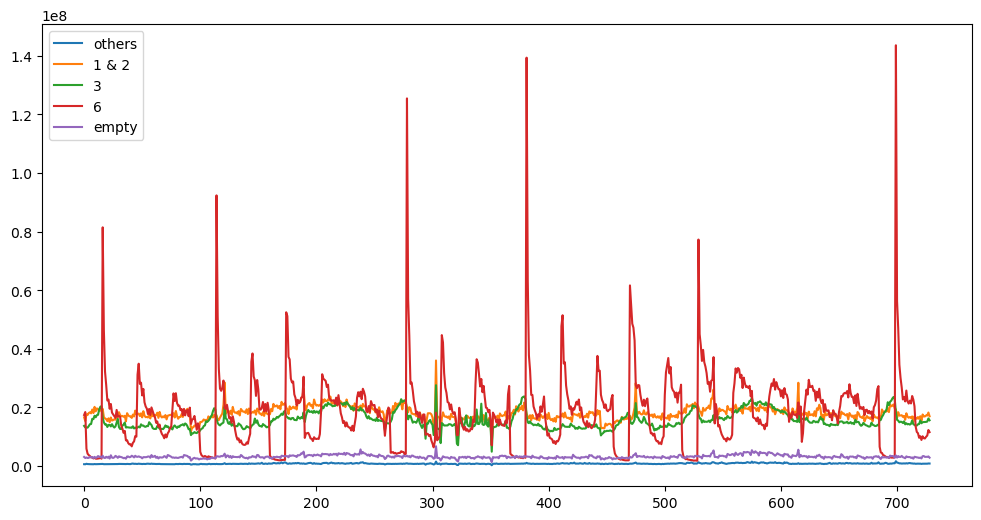

In [7]:
# Plotting the revenues 
plt.figure(figsize=(12, 6))

other_subscriptions_df["REVENUE"].plot(label="others")
subscriptions_1_2_df["REVENUE"].plot(label="1 & 2")
subscriptions_3_df["REVENUE"].plot(label="3")
subscriptions_6_df["REVENUE"].plot(label="6")
empty_subscription_df["REVENUE"].plot(label="empty")

plt.legend()

In [8]:
# Importing the necessary libraries for the training and standarization
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Importing the libraries to save the scalers for later use
import pickle

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback to be able to not train non performant models
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=50,          
    verbose=1,           
    restore_best_weights=True
)

# LSTM of offers : 
<h1 style="color:red;">1 and 2</h1>

In [9]:
# Defining the grouped_df to be used here which is the 1_2 dataframe
grouped_df = subscriptions_1_2_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [29]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_1_2.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [30]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [15]:
# Defining the LSTM model
model_1_2 = Sequential()
model_1_2.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_1_2.add(LSTM(68, return_sequences=True))  
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(68, return_sequences=True))  
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(68, return_sequences=True))  
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(68, return_sequences=True))  
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(16, return_sequences=False)) 
model_1_2.add(Dense(1))
model_1_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 68)               │          35,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 16)                  │           5,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,609 (596.13 KB)

 Trainable params: 152,609 (596.13 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile the model
model_1_2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_1_2 = model_1_2.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.2569 - val_loss: 0.0427
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0687 - val_loss: 0.0376
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0600 - val_loss: 0.0465
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0618 - val_loss: 0.0370
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0562 - val_loss: 0.0454
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0560 - val_loss: 0.0394
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0498 - val_loss: 0.0475
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0420 - val_loss: 0.0347
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0456 - val_loss: 0.0536
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0488 - val_loss: 0.0332
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0466 - val_loss: 0.0327
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 - val_loss: 0.0230
Epoch 138/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0326 - val_loss: 0.0324
Epoch 139/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - val_loss: 0.0225
Epoch 140/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259 - val_loss: 0.0218
Epoch 141/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0263 - val_loss: 0.0232
Epoch 142/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0284 - val_loss: 0.0276
Epoch 143/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0289 - val_loss: 0.0250
Epoch 144/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0311 - val_loss: 0.0228
Epoch 145/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0323 - val_loss: 0.0228
Epoch 146/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297 - val_loss: 0.0228
Epoch 147/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0314 - val_loss: 0.0254
Epoch 148/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

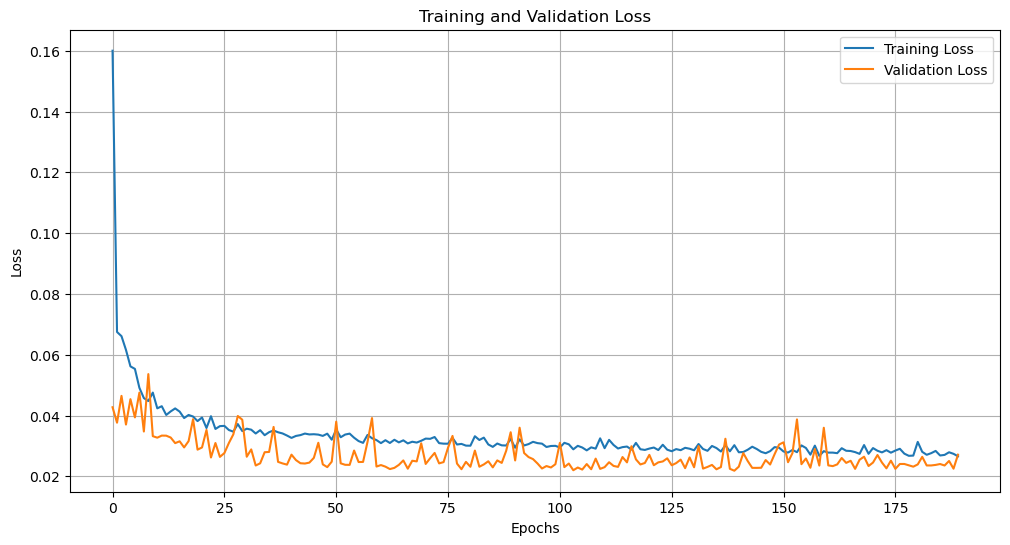

In [17]:
# Checking if there is a overfitting

history_dict = history_1_2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_1_2.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_1_2 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_1_2

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step


,test,pred,diff_val_by_million,diff_percentage
0,20413232.0,19646814.0,0.766418,3.754516
1,20513437.0,18958246.0,1.555191,7.581328
2,20025826.0,19304956.0,0.720870,3.599702
3,19861678.0,19630078.0,0.231600,1.166065
4,18612033.0,18720706.0,0.108673,0.583886
...,...,...,...,...
135,16927325.0,17146750.0,0.219425,1.296277
136,17288519.0,17189846.0,0.098673,0.570743
137,17239755.0,16674694.0,0.565061,3.277663
138,18269577.0,17717682.0,0.551895,3.020842


count    140.000000
mean       3.386637
std        4.254479
min        0.005688
25%        0.717038
50%        2.378477
75%        4.585390
max       34.405351
Name: diff_percentage, dtype: float64


<Axes: >

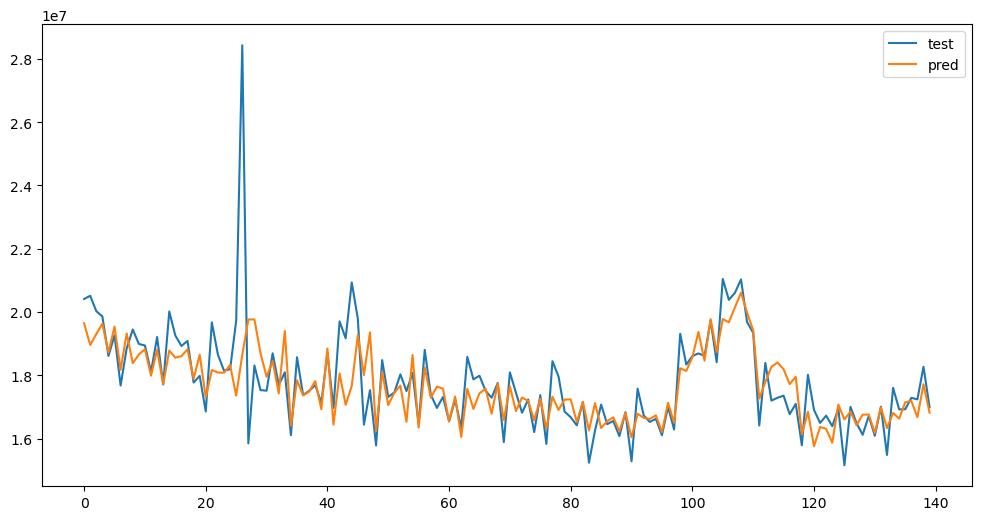

In [19]:
print(data_1_2["diff_percentage"].describe())

data_1_2[["test","pred"]].plot(figsize=(12, 6))

In [20]:
# Saving the model

model_1_2.save('../Saved Models/m_1_2.keras')

# LSTM of offers : 
<h1 style="color:red;">empty</h1>

In [10]:
# Defining the grouped_df to be used here which is the 1_2 dataframe
grouped_df = empty_subscription_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [18]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_empty.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [19]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [22]:
# Defining the LSTM model
model_empty= Sequential()
model_empty.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_empty.add(LSTM(500, return_sequences=True))  
model_empty.add(Dropout(0.1))  
model_empty.add(LSTM(300, return_sequences=True)) 
model_empty.add(Dropout(0.1)) 
model_empty.add(LSTM(300, return_sequences=True)) 
model_empty.add(Dropout(0.2))  
model_empty.add(LSTM(300, return_sequences=True)) 
model_empty.add(Dropout(0.15))
model_empty.add(LSTM(350, return_sequences=False)) 
model_empty.add(Dense(1))
model_empty.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,439,351 (16.93 MB)

 Trainable params: 4,439,351 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Compile the model
model_empty.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_absolute_error')

# Fit the model
history_empty = model_empty.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 0.0578 - val_loss: 0.0509
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0576 - val_loss: 0.0506
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0556 - val_loss: 0.0599
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0588 - val_loss: 0.0663
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0527 - val_loss: 0.0502
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0529 - val_loss: 0.0548
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0529 - val_loss: 0.0475
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0528 - val_loss: 0.0500
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0556 - val_loss: 0.0472
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0576 - val_loss: 0.0499
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0562 - val_loss: 0.0451
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/ste

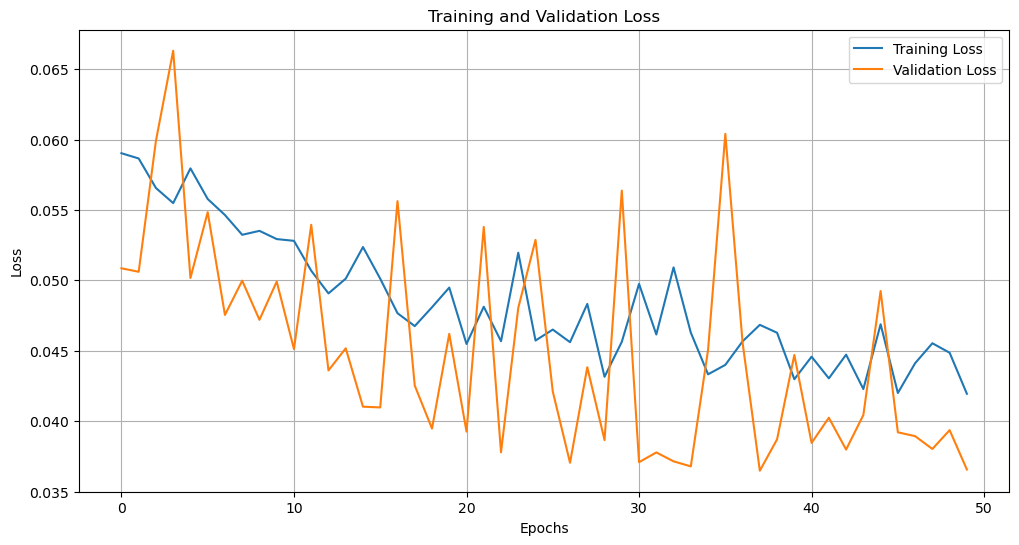

In [44]:
# Checking if there is a overfitting

history_dict = history_empty.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_empty.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_empty = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_empty

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


,test,pred,diff_val_by_million,diff_percentage
0,4665027.0,4324796.00,0.340231,7.293227
1,4767666.0,4261377.00,0.506289,10.619221
2,4447449.0,4335865.50,0.111584,2.508933
3,4513899.0,4353623.50,0.160275,3.550711
4,4217737.0,4316030.00,0.098293,2.330468
...,...,...,...,...
135,3122199.0,2941175.25,0.181024,5.797957
136,3160835.0,2912059.50,0.248776,7.870563
137,3138806.0,2870450.25,0.268356,8.549612
138,3288562.0,2906683.75,0.381878,11.612317


count    140.000000
mean       8.463042
std        6.866746
min        0.333308
25%        3.562026
50%        6.515687
75%       11.479473
max       35.360117
Name: diff_percentage, dtype: float64


<Axes: >

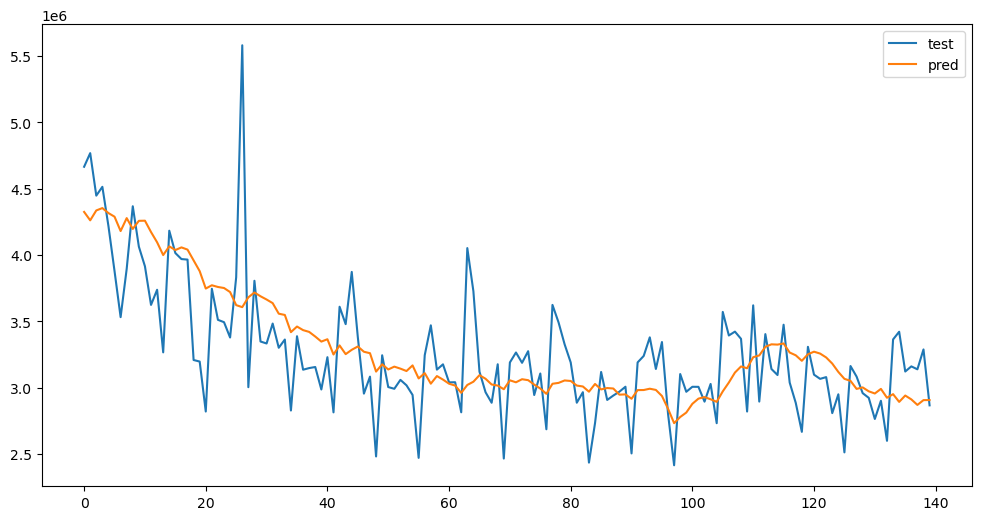

In [21]:
print(data_empty["diff_percentage"].describe())

data_empty[["test","pred"]].plot(figsize=(12, 6))

In [47]:
# Saving the model

model_empty.save('../Saved Models/m_empty.keras')

# LSTM of offers : 
<h1 style="color:red;">others</h1>

In [11]:
# Defining the grouped_df to be used here which is the other_subscritions dataframe
grouped_df = other_subscriptions_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [23]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_others.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [24]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [51]:
# Defining the LSTM model
model_others= Sequential()
model_others.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_others.add(LSTM(500, return_sequences=True))  
model_others.add(Dropout(0.1))  
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.1)) 
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.2))  
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.15))
model_others.add(LSTM(350, return_sequences=False)) 
model_others.add(Dense(1))
model_others.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,439,351 (16.93 MB)

 Trainable params: 4,439,351 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compile the model
model_others.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_others = model_others.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.1176 - val_loss: 0.0735
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0749 - val_loss: 0.0938
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0699 - val_loss: 0.0717
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0720 - val_loss: 0.0924
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0723 - val_loss: 0.0683
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0795 - val_loss: 0.0663
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0701 - val_loss: 0.0967
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0750 - val_loss: 0.0638
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0664 - val_loss: 0.0934
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0722 - val_loss: 0.0646
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0673 - val_loss: 0.0830
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/ste

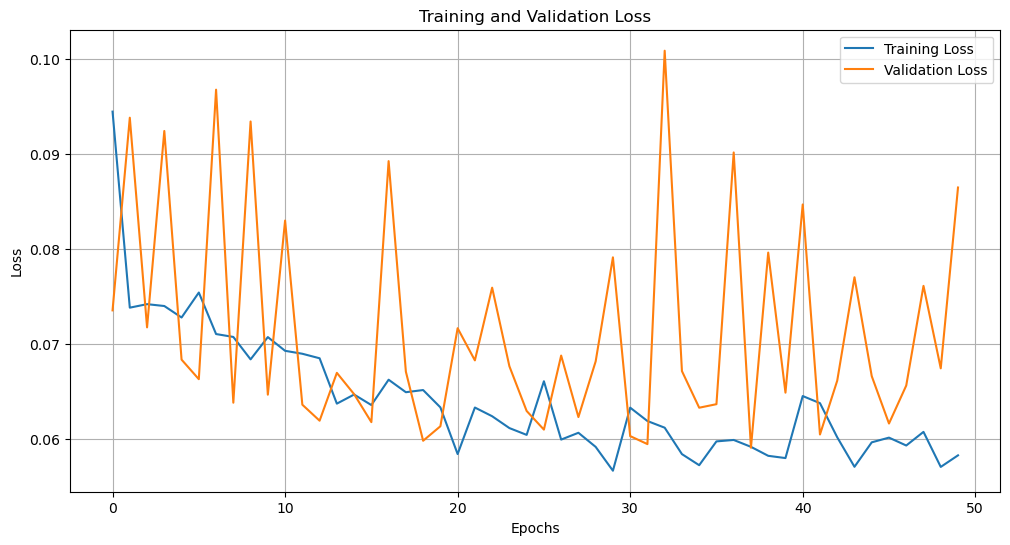

In [65]:
# Checking if there is a overfitting

history_dict = history_others.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_others.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_others = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_others

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 653ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001DA178A60C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


,test,pred,diff_val_by_million,diff_percentage
0,1016700.0,961290.6250,0.055409,5.449924
1,1147061.0,959066.5625,0.187994,16.389228
2,1200801.0,961691.3125,0.239110,19.912516
3,1140590.0,965089.8125,0.175500,15.386790
4,1149509.0,964173.5000,0.185335,16.123014
...,...,...,...,...
135,810533.0,800879.0000,0.009654,1.191068
136,830240.0,798139.1875,0.032101,3.866450
137,813926.0,801644.6250,0.012281,1.508906
138,884362.0,804160.3125,0.080202,9.068875


count    140.000000
mean       9.414882
std        8.325570
min        0.035263
25%        3.071666
50%        7.087638
75%       12.877184
max       46.978760
Name: diff_percentage, dtype: float64


<Axes: >

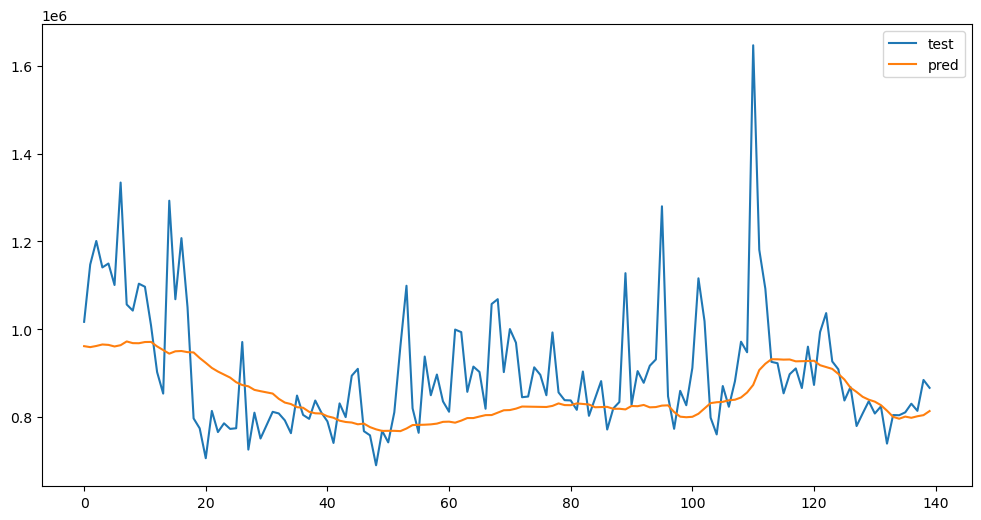

In [26]:
print(data_others["diff_percentage"].describe())

data_others[["test","pred"]].plot(figsize=(12, 6))

In [68]:
# Saving the model

model_others.save('../Saved Models/m_others.keras')

# LSTM of offers : 
<h1 style="color:red;">3</h1>

In [12]:
# Defining the grouped_df to be used here which is the subscription_3 dataframe
grouped_df = subscriptions_3_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [28]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_3.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [29]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [72]:
# Defining the LSTM model
model_3= Sequential()
model_3.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_3.add(LSTM(500, return_sequences=True))  
model_3.add(Dropout(0.1))  
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.1)) 
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.2))  
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.15))
model_3.add(LSTM(350, return_sequences=False)) 
model_3.add(Dense(1))
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,439,351 (16.93 MB)

 Trainable params: 4,439,351 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error')

# Fit the model
history_3 = model_3.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - loss: 0.0678 - val_loss: 0.0339
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0627 - val_loss: 0.0449
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0563 - val_loss: 0.0814
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0641 - val_loss: 0.0387
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0486 - val_loss: 0.0680
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0612 - val_loss: 0.0374
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0519 - val_loss: 0.0462
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0474 - val_loss: 0.0649
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0516 - val_loss: 0.0270
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0483 - val_loss: 0.0265
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0434 - val_loss: 0.0271
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/ste

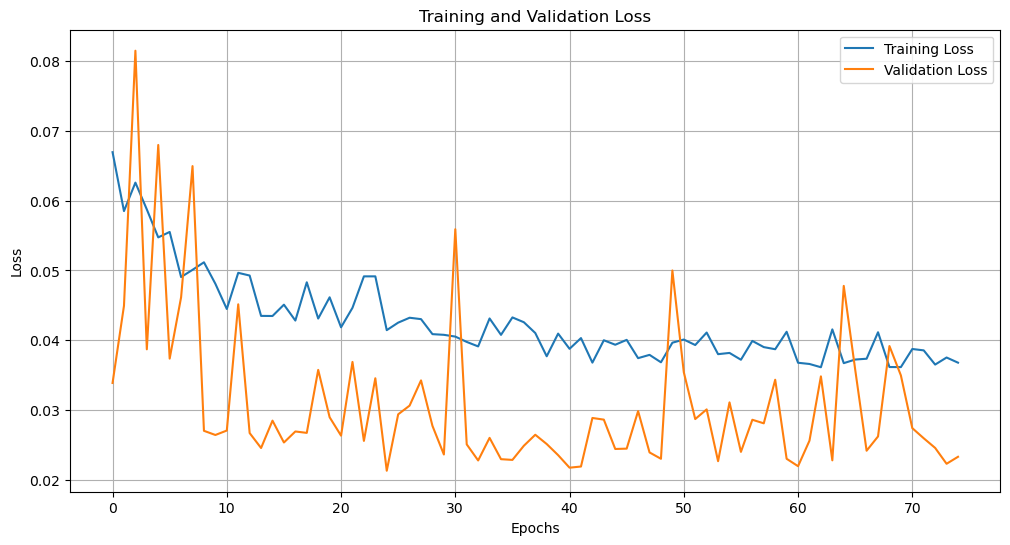

In [75]:
# Checking if there is a overfitting

history_dict = history_3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_3.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_3 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_3

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


,test,pred,diff_val_by_million,diff_percentage
0,21394223.0,21275762.0,0.118461,0.553706
1,21137938.0,21114702.0,0.023236,0.109926
2,21062921.0,21024370.0,0.038551,0.183028
3,20944361.0,20901060.0,0.043301,0.206743
4,19755915.0,20817024.0,1.061109,5.371095
...,...,...,...,...
135,15016794.0,15258648.0,0.241854,1.610557
136,15079800.0,15206580.0,0.126780,0.840727
137,15186554.0,15120942.0,0.065612,0.432040
138,16245678.0,15355568.0,0.890110,5.479057


count    140.000000
mean       3.021048
std        2.951066
min        0.006447
25%        0.957935
50%        2.058137
75%        4.466298
max       19.814195
Name: diff_percentage, dtype: float64


<Axes: >

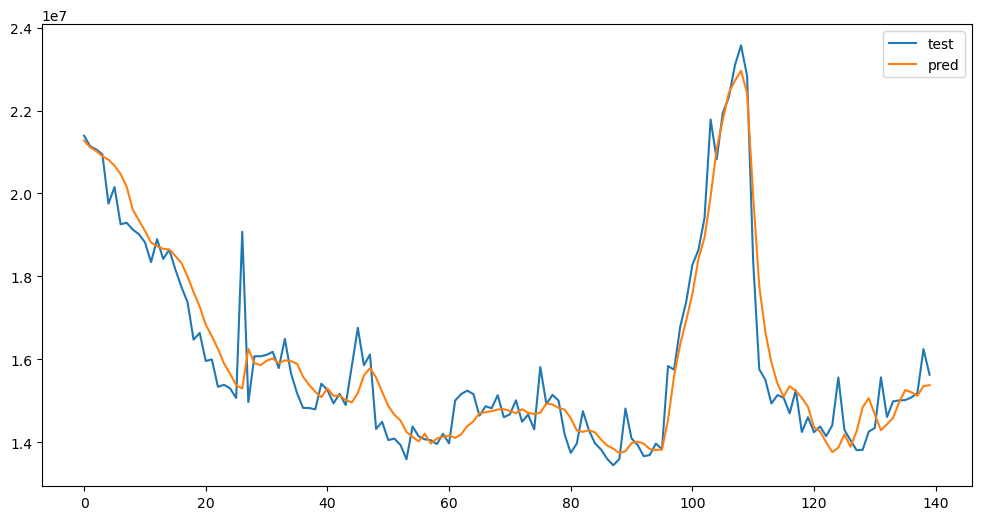

In [31]:
print(data_3["diff_percentage"].describe())

data_3[["test","pred"]].plot(figsize=(12, 6))

In [78]:
# Saving the model

model_3.save('../Saved Models/m_3.keras')

# LSTM of offers : 
<h1 style="color:red;">6</h1>

In [13]:
# Defining the grouped_df to be used here which is the subscription_6 dataframe
grouped_df = subscriptions_6_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [33]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_6.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [34]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [82]:
# Defining the LSTM model
model_6 = Sequential()
model_6.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(16, return_sequences=False)) 
model_6.add(Dense(1))
model_6.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 1, 68)               │          35,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 16)                  │           5,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,609 (596.13 KB)

 Trainable params: 152,609 (596.13 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# Compile the model
model_6.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_6 = model_6.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0879 - val_loss: 0.0399
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0474 - val_loss: 0.0319
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0354 - val_loss: 0.0287
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0317 - val_loss: 0.0369
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0371 - val_loss: 0.0352
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0293 - val_loss: 0.0300
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0242 - val_loss: 0.0212
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0246 - val_loss: 0.0345
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0301 - val_loss: 0.0209
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0245 - val_loss: 0.0342
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0220 - val_loss: 0.0203
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 138/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - val_loss: 0.0121
Epoch 139/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 - val_loss: 0.0128
Epoch 140/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - val_loss: 0.0200
Epoch 141/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - val_loss: 0.0118
Epoch 142/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0147
Epoch 143/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 144/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - val_loss: 0.0156
Epoch 145/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0131
Epoch 146/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - val_loss: 0.0115
Epoch 147/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - val_loss: 0.0178
Epoch 148/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - lo

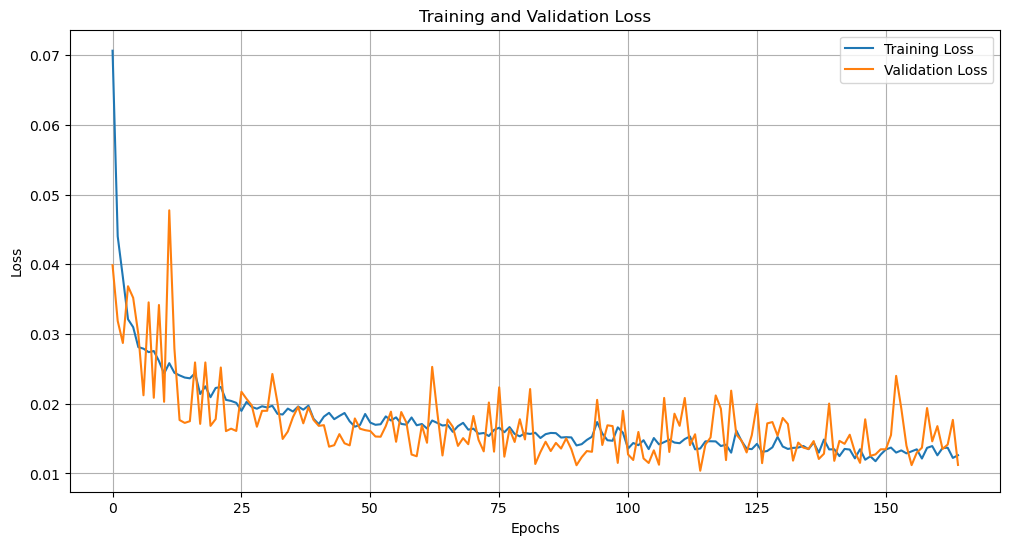

In [84]:
# Checking if there is a overfitting

history_dict = history_6.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_6.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_6 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_6

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


,test,pred,diff_val_by_million,diff_percentage
0,19997313.0,18334996.0,1.662317,8.312702
1,23733488.0,21904620.0,1.828868,7.705854
2,26238583.0,26251512.0,0.012929,0.049275
3,28187865.0,28029094.0,0.158771,0.563260
4,27356556.0,29131540.0,1.774984,6.488331
...,...,...,...,...
135,9418133.0,8184260.5,1.233872,13.101031
136,9996085.0,8269096.5,1.726989,17.276649
137,10411340.0,8502549.0,1.908791,18.333769
138,12305902.0,12195446.0,0.110456,0.897586


count    140.000000
mean      10.502135
std       14.880038
min        0.049275
25%        2.358691
50%        5.640920
75%       10.572693
max      124.757905
Name: diff_percentage, dtype: float64


<Axes: >

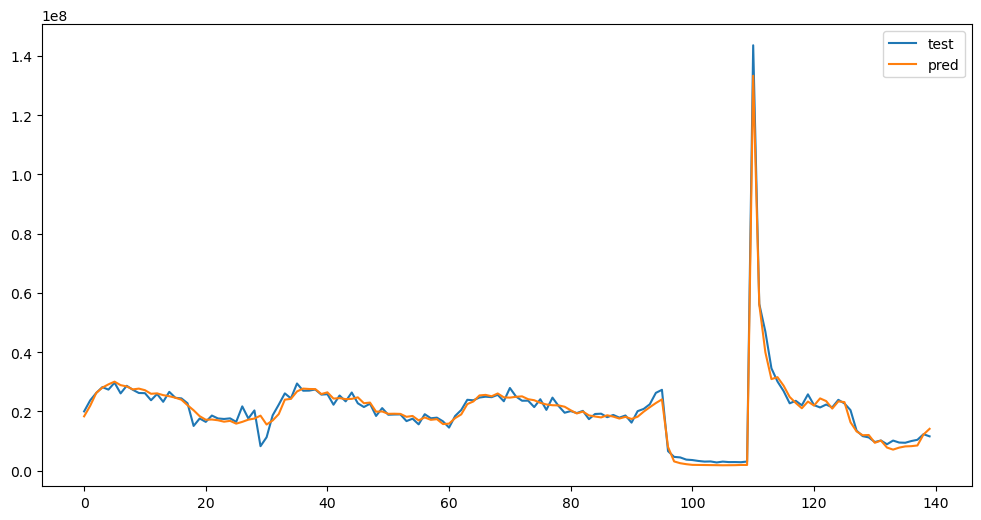

In [36]:
print(data_6["diff_percentage"].describe())

data_6[["test","pred"]].plot(figsize=(12, 6))

In [87]:
# Saving the model

model_6.save('../Saved Models/m_6.keras')

# Fusing all the models into one

<Axes: >

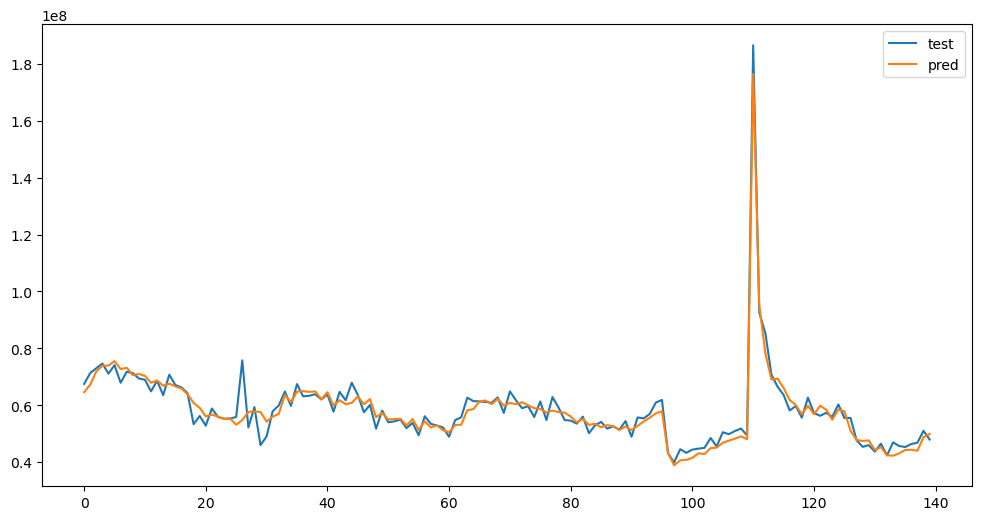

In [37]:
sum_df = pd.DataFrame({
    'test': data_1_2["test"] + data_others["test"] + data_empty["test"] + data_3["test"] + data_6["test"],
    'pred': data_1_2["pred"] + data_others["pred"] + data_empty["pred"] + data_3["pred"] + data_6["pred"]
})

sum_df.plot(figsize=(12, 6))


In [38]:
sum_df

,test,pred
0,67486495.0,64566524.0
1,71299590.0,67226912.0
2,72975580.0,71898536.0
3,74648393.0,73865088.0
4,71091750.0,73954832.0
...,...,...
135,45294984.0,44261508.0
136,46355479.0,44311888.0
137,46790381.0,43979704.0
138,50994081.0,48761712.0


In [90]:
data_1_2["test"] + data_others["test"] + data_empty["test"] + data_3["test"] + data_6["test"]

0      67486495.0
1      71299590.0
2      72975580.0
3      74648393.0
4      71091750.0
          ...    
135    45294984.0
136    46355479.0
137    46790381.0
138    50994081.0
139    47933808.0
Name: test, Length: 140, dtype: float64

In [39]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(sum_df.dropna().test,sum_df.dropna().pred)/sum_df["test"].mean() *100

3.8975271508570914